# fpgaConvNet Optimiser Tutorial

The [fpgaConvNet Optimiser](https://github.com/AlexMontgomerie/fpgaconvnet-optimiser) is the frontend for generating the dataflow hardware configuration for a given convolutional neural network. In this tutorial, The main aspects to this optimiser will be covered. A step by step guide of stages to the model to hardware description is given. Instructions on using the command-line interface are given towards the end.

In [1]:
# setup environment
!python -m pip install --upgrade fpgaconvnet-optimiser-AlexMontgomerie==0.0.6
!python -m pip install onnxruntime
!wget https://www.dropbox.com/s/9ua1diq2fd254ab/lenet.onnx
!mkdir figures
from IPython.display import Image

--2021-02-20 18:48:55--  https://www.dropbox.com/s/9ua1diq2fd254ab/lenet.onnx
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6020:18::a27d:4012, 162.125.64.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6020:18::a27d:4012|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9ua1diq2fd254ab/lenet.onnx [following]
--2021-02-20 18:48:56--  https://www.dropbox.com/s/raw/9ua1diq2fd254ab/lenet.onnx
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc84b131b7a8dd3cc9f5b8bf8727.dl.dropboxusercontent.com/cd/0/inline/BJVcdUBXNrEGwFabmD-YDDa6yRTlQNq-jXcOvB785MgnS6EzE0Q_WHOWoYwXoS-J12-NElfi8PAc4w5dXmSjSwyN2i0U3QEYkEXRBrNj4SBvHpqFemtS1h2LqHLl-zoa-pA/file# [following]
--2021-02-20 18:48:56--  https://uc84b131b7a8dd3cc9f5b8bf8727.dl.dropboxusercontent.com/cd/0/inline/BJVcdUBXNrEGwFabmD-YDDa6yRTlQNq-jXcOvB785MgnS6EzE0Q_WHOWoYwXoS-J12-NElfi8PAc4w5dXmSjSwyN2i0U3QEYkE

## 1. Initialising a Hardware Model

The first step is parsing the CNN model into an initial hardware model. This initial hardware model is a very basic implementation, which maps the CNN layers to their hardware equivalent. There is no parallelism in this intial model, and serves as a baseline for a feasible hardware implementation.

To initialise the hardware model, a `Network` class is from the given network description. In this tutorial, the [LeNet]() CNN model is used.

In [2]:
from fpgaconvnet_optimiser.models.network import Network

# create network
lenet = Network("lenet", "lenet.onnx")
lenet.update_partitions() 

We have now initialised the hardware model, however it doesn't have knowledge of the hardware constraints. We can do this by uploading a platform configuration file.

latency (ms):  0.016068288
throughput (fps):  62.234383650579325


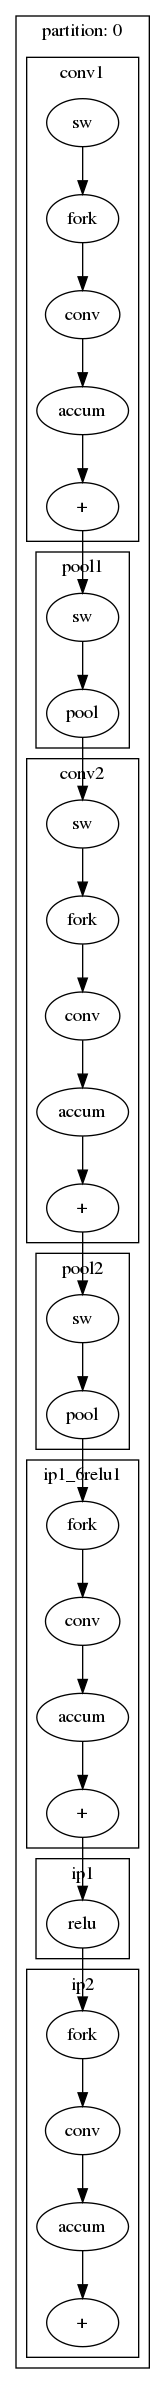

In [3]:
# give hardware model a platform configuration
lenet.update_platform("zedboard.json")

# get resource and performance estimates
print("latency (ms): ", lenet.get_latency())
print("throughput (fps): ", lenet.get_throughput())

# visualise network
lenet.visualise("figures/lenet_baseline.png")
Image(filename="figures/lenet_baseline.png")

## 2. Transforms

So far we have an initial hardware model, but with very poor performance. The next step is performing optimisations to better map the CNN model to the hardware.

### 2.1 Partitioning

The first transform we are going to apply is partitioning. The partitioning transform can split the computation graph into seperate subgraphs. At runtime, these subgraphs are run sequentially by re-programming the device. The purpose of this transform is to reduce resource usage for a given partition. 

First, all the available graph splits can be shown. There are two types of splits: vertical and horizontal. Horizontial splits two sequential nodes, and vertical splits a parallel path of computation.

In [4]:
# get all avaiable partitions
print("all horizontal splits: ", lenet.get_all_horizontal_splits(0))

all horizontal splits:  [('conv1', 'pool1'), ('pool1', 'conv2'), ('conv2', 'pool2'), ('pool2', 'ip1_6relu1'), ('ip1_6relu1', 'ip1'), ('ip1', 'ip2')]


A split between the `pool2` node and the `ip1_6relu1` node is applied, seperating the original network into two seperate partitions.

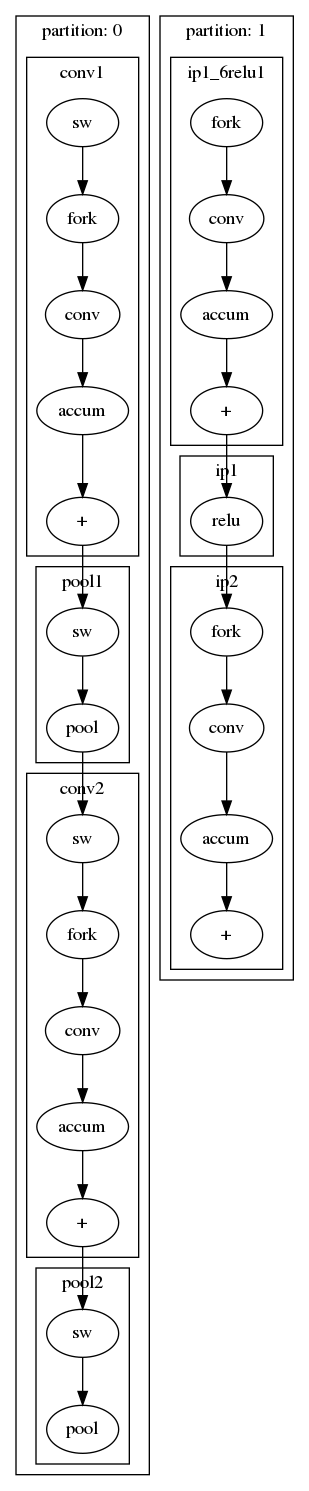

In [5]:
# split all partitions
lenet.split_horizontal(0,("pool2","ip1_6relu1"))

# visualise network
lenet.visualise("figures/lenet_partitioned.png")
Image(filename="figures/lenet_partitioned.png") 

### Fine Folding

The next transform introduced is fine-grain folding. This transform is applied to the `Conv` module, and defines the degree of parallelism at the kernel level. Essentially, the fine factor dictates the number of multipliers used in the dot-product computation.

This transform trades of resource usage with performance. Let's first see what our baseline resource and performance is. Latency describes the number of clock cycles needed to compute the given node.

In [6]:
# show rates before
print(f"latency conv1 (fine = {lenet.partitions[0].graph.nodes['conv1']['hw'].fine}) : {lenet.partitions[0].graph.nodes['conv1']['hw'].get_latency()}")
print(f"latency conv2 (fine = {lenet.partitions[0].graph.nodes['conv2']['hw'].fine}) : {lenet.partitions[0].graph.nodes['conv2']['hw'].get_latency()}")
print("\n")

# show resource usage before
print(f"conv1 resource usage : {lenet.partitions[0].graph.nodes['conv1']['hw'].resource()}")
print(f"conv2 resource usage : {lenet.partitions[0].graph.nodes['conv2']['hw'].resource()}")  

latency conv1 (fine = 1) : 288000.0
latency conv2 (fine = 1) : 1599999.9999999998


conv1 resource usage : {'LUT': 0, 'FF': 0, 'BRAM': 25, 'DSP': 1}
conv2 resource usage : {'LUT': 0, 'FF': 0, 'BRAM': 27, 'DSP': 1}


We can see that there is very little resource usage but also poor performance. Let's next see what fine-grain folding factors we can apply to the network. 

In [7]:
# get possible fine factors
print("possible fine (conv1): ", lenet.partitions[0].graph.nodes['conv1']['hw'].get_fine_feasible())
print("possible fine (conv2): ", lenet.partitions[0].graph.nodes['conv2']['hw'].get_fine_feasible())

possible fine (conv1):  [1, 5, 25]
possible fine (conv2):  [1, 5, 25]


The fine-grain folding factors are factors of the kernel size. Finally, lets apply the maximum fine-grain folding factor and see how this impacts performance and resources.

In [8]:
# update fine factors
lenet.partitions[0].graph.nodes['conv1']['hw'].fine = 25
lenet.partitions[0].graph.nodes['conv2']['hw'].fine = 25
lenet.update_partitions()

# show updated rates
print(f"latency conv1 (fine = {lenet.partitions[0].graph.nodes['conv1']['hw'].fine}) : {lenet.partitions[0].graph.nodes['conv1']['hw'].get_latency()}")
print(f"latency conv2 (fine = {lenet.partitions[0].graph.nodes['conv2']['hw'].fine}) : {lenet.partitions[0].graph.nodes['conv2']['hw'].get_latency()}")
print("\n")

# show updated resource usage
print(f"conv1 resource usage : {lenet.partitions[0].graph.nodes['conv1']['hw'].resource()}")
print(f"conv2 resource usage : {lenet.partitions[0].graph.nodes['conv2']['hw'].resource()}")  

latency conv1 (fine = 25) : 11520.000000000002
latency conv2 (fine = 25) : 2880.0


conv1 resource usage : {'LUT': 0, 'FF': 0, 'BRAM': 49, 'DSP': 25}
conv2 resource usage : {'LUT': 0, 'FF': 0, 'BRAM': 50, 'DSP': 25}


It is worth pointing out that this transform also affects `BRAM` usage, as more multipliers require more `BRAM` ports to read the filter coefficients.

### Coarse Folding

The coarse folding transform defines parallelism across the channel and filter dimensions. It tells us the number of parallel streams in and out of the device. 

Let's change the coarse grain folding factor for different layers in first partition. The `conv1`, `pool1`, `conv2` layers are updated.

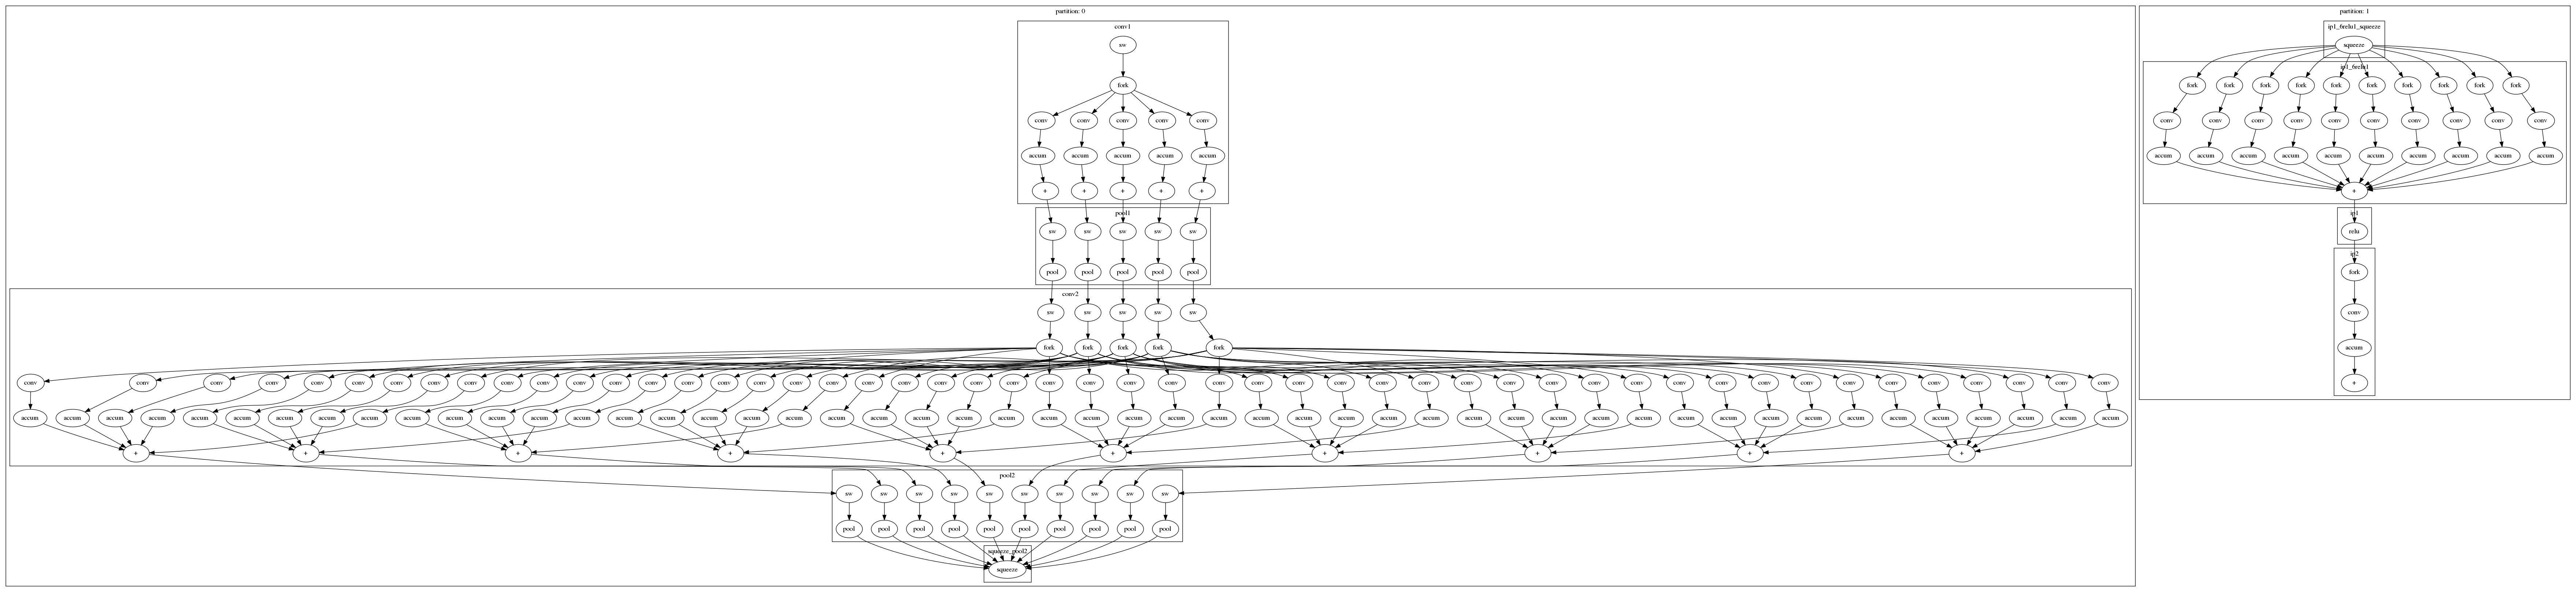

In [9]:
# update coarse factors

## conv1
lenet.partitions[0].graph.nodes['conv1']['hw'].update_coarse_out(5)

## pool1
lenet.partitions[0].graph.nodes['pool1']['hw'].update_coarse_in(5)

## conv2
lenet.partitions[0].graph.nodes['conv2']['hw'].update_coarse_in(5)
lenet.partitions[0].graph.nodes['conv2']['hw'].update_coarse_out(10)

## pool2
lenet.partitions[0].graph.nodes['pool2']['hw'].update_coarse_in(10)

lenet.update_partitions()

# visualise network
lenet.visualise("figures/lenet_coarse.png")
Image(filename="figures/lenet_coarse.png") 

We can see that the coarse factors lead to duplication of modules within the layer, allowing for this parallelism. It's worth noting that there are restrictions on the coarse factors. For example, Pooling layers must have the same input and output coarse factor. `Squeeze` layers are added to allow for difference in two sequential coarse factors.

### Weights Reloading

The final transform we will look at is the weights reloading transform. For dataflow-driven CNN accelerators, on-chip memory becomes the largest resource 